# Dependencies

In [16]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os
import kagglehub
import shutil
import cv2 
from tqdm import tqdm
import matplotlib.pyplot as plt


In [3]:
if torch.cuda.is_available():
    print("GPU is available.")
    print("Device Name:", torch.cuda.get_device_name(0))
    if "T4" in torch.cuda.get_device_name(0):
        print("T4 GPU is being used.")
    else:
        print("A GPU is available, but it is not a T4.")
else:
    print("No GPU available, using CPU.")

GPU is available.
Device Name: Tesla T4
T4 GPU is being used.


# Download the dataset

In [4]:
path_cache = kagglehub.dataset_download("gpiosenka/sports-classification")
print("Path :", path_cache)

train_path = os.path.join(path_cache, 'train')
test_path = os.path.join(path_cache, 'test')
valid_path = os.path.join(path_cache, 'valid')

print("Train path:", train_path)
print("Test path:", test_path)
print("Validation path:", valid_path)



Path : /kaggle/input/sports-classification
Train path: /kaggle/input/sports-classification/train
Test path: /kaggle/input/sports-classification/test
Validation path: /kaggle/input/sports-classification/valid


# EDA : Exploratory Data Analysis

In [5]:
for folder in os.listdir(train_path):
    print(f"{folder}: {len(os.listdir(os.path.join(train_path, folder)))} images")

bobsled: 138 images
hurdles: 136 images
snow boarding: 117 images
fly fishing: 134 images
luge: 127 images
sidecar racing: 133 images
ampute football: 112 images
volleyball: 142 images
billiards: 145 images
giant slalom: 150 images
tennis: 131 images
horse racing: 139 images
pole dancing: 112 images
figure skating women: 157 images
rollerblade racing: 159 images
fencing: 135 images
olympic wrestling: 167 images
golf: 157 images
ultimate: 97 images
harness racing: 147 images
football: 191 images
frisbee: 131 images
bungee jumping: 125 images
shot put: 149 images
ice climbing: 130 images
figure skating men: 128 images
rowing: 143 images
bike polo: 110 images
swimming: 157 images
judo: 150 images
axe throwing: 113 images
archery: 132 images
baseball: 174 images
wheelchair basketball: 106 images
log rolling: 128 images
lacrosse: 151 images
rock climbing: 141 images
horse jumping: 134 images
hydroplane racing: 108 images
formula 1 racing: 190 images
curling: 141 images
jousting: 118 images


Visualize an example image : 

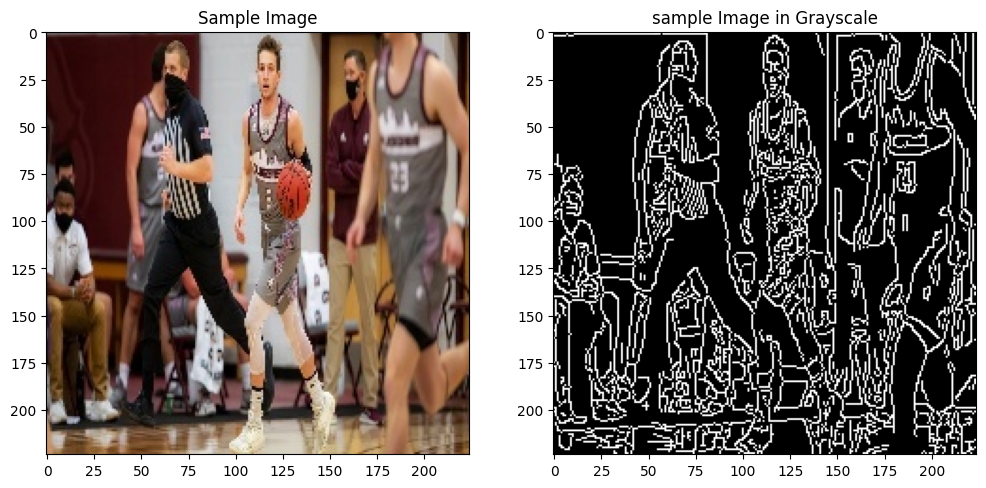

In [6]:
img = cv2.imread(f'{train_path}/basketball/001.jpg')

# Display the image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Sample Image")

# Display the image in grayscale
plt.subplot(1, 2, 2)
edges = cv2.Canny(img, 100, 200)
plt.imshow(edges, cmap='gray')
plt.title("sample Image in Grayscale")

plt.show()

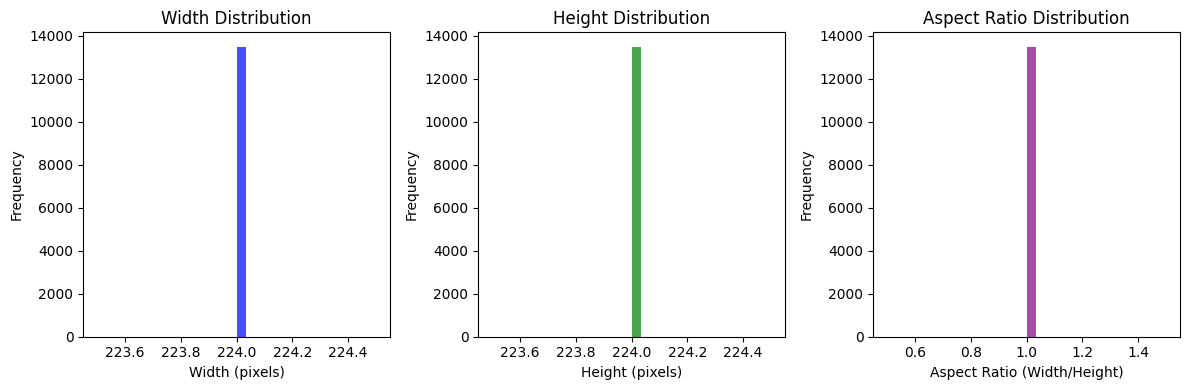

In [7]:
image_size = []
aspect_ratios = []

for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            h, w, _ = img.shape
            image_size.append((w, h))
            aspect_ratios.append(w / h)
            
# Visualize distribution 
w = [size[0] for size in image_size] 
h = [size[1] for size in image_size]

plt.figure(figsize=(12, 4))

# Histogram Width distribution
plt.subplot(1, 3, 1)
plt.hist(w, bins=30, color='blue', alpha=0.7)
plt.title('Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

# Histogram Height distribution
plt.subplot(1, 3, 2)
plt.hist(h, bins=30, color='green', alpha=0.7)
plt.title('Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

# Histogram Aspect Ratio distribution
plt.subplot(1, 3, 3)
plt.hist(aspect_ratios, bins=30, color='purple', alpha=0.7)
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Define image Data Generator + rescale

In [8]:
# Parameters
batch_size = 32
image_size = (224, 224)

# Augmentation for training data
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Datasets ---
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
valid_dataset = datasets.ImageFolder(valid_path, transform=valid_transform)
test_dataset  = datasets.ImageFolder(test_path, transform=valid_transform)

# --- Dataloaders ---
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Nombre de classes
num_classes = len(train_dataset.classes)
print("Nombre de classes :", num_classes)

Nombre de classes : 100


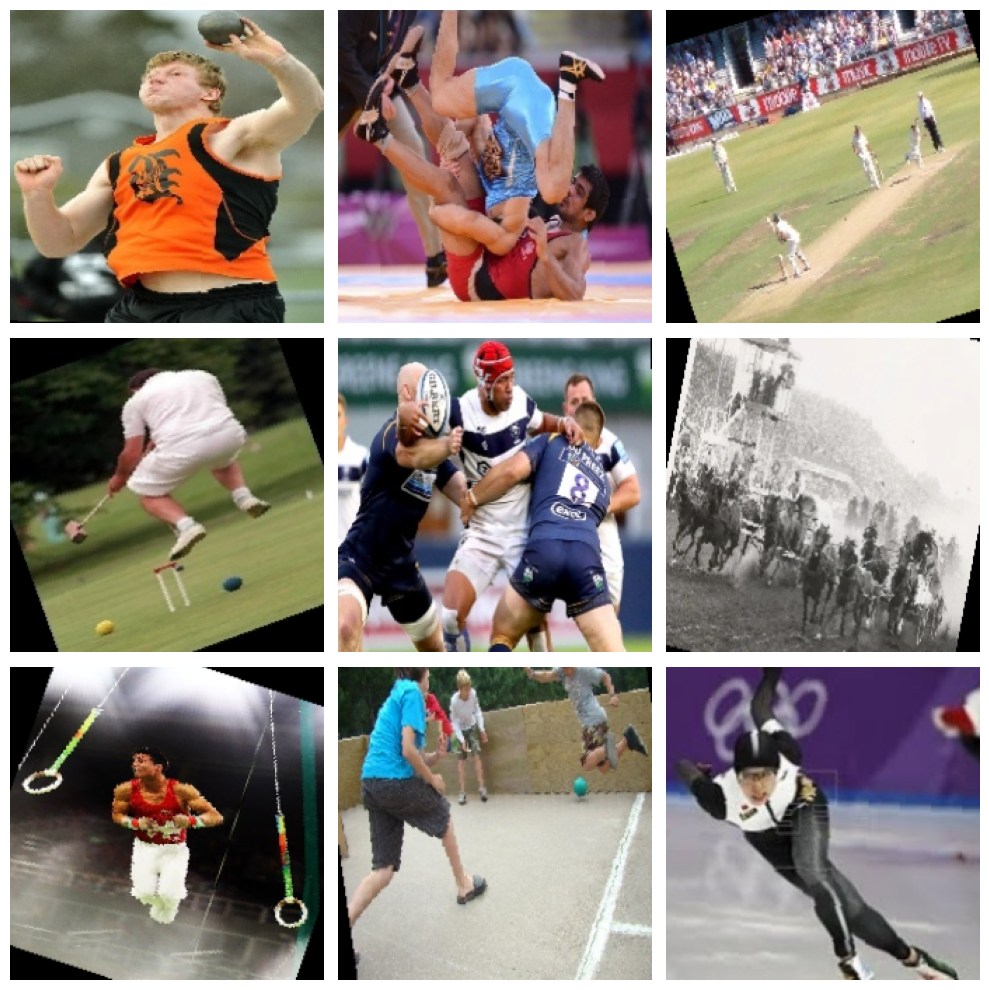

In [9]:
# Visualize some augmented images
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Get a batch of training data
inputs, labels = next(iter(train_loader))

# Convert tensors to numpy for visualization
inputs_np = inputs.cpu().numpy()

plt.figure(figsize=(10,10))

# Plot 9 images
for i in range(9):
    plt.subplot(3,3,int(i+1))
    img = inputs_np[i].transpose((1,2,0))  
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Create Model

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create Model
base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Fine-tune last 5 layers of layer4
for param in list(base_model.layer4.parameters())[-5:]:
    param.requires_grad = True
    
# Replace the final fully connected layer
base_model.fc = nn.Sequential(
    nn.Linear(base_model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

base_model = base_model.to(device)

# Print model summary
print(base_model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 179MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Model Training

In [11]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr=0.0001)

In [12]:
# TRAINING
num_epochs = 5

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    base_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc="Training", leave=True)

    for inputs, labels in progress_bar:   
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        outputs = base_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        progress_bar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{(correct / total):.4f}"
        })
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # VALIDATION 
    base_model.eval()
    
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    val_bar = tqdm(valid_loader, desc="Validation", leave=True)
        
    with torch.no_grad():  # important pour ne pas calculer les gradients
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = base_model(inputs)
            loss = criterion(outputs, labels)
                
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
                
            val_bar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "acc": f"{(val_correct/val_total):.4f}"
            })
        
    epoch_val_loss = val_loss / len(valid_loader.dataset)
    epoch_val_acc = val_correct / val_total
    valid_losses.append(epoch_val_loss)
    valid_accuracies.append(epoch_val_acc)
    
    print(len(train_losses), len(valid_losses), len(train_accuracies), len(valid_accuracies))
        
    print(f"Epoch {epoch+1} summary -> "
            f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
            f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

Validation: 100%|██████████| 16/16 [00:04<00:00,  3.67it/s, loss=0.6733, acc=0.7640]


1 1 1 1
Epoch 1 summary -> Train Loss: 2.8379, Train Acc: 0.3604 | Val Loss: 1.0005, Val Acc: 0.7640


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.24it/s, loss=0.2036, acc=0.8960]


2 2 2 2
Epoch 2 summary -> Train Loss: 1.0675, Train Acc: 0.7356 | Val Loss: 0.3808, Val Acc: 0.8960


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.1607, acc=0.9120]


3 3 3 3
Epoch 3 summary -> Train Loss: 0.6112, Train Acc: 0.8461 | Val Loss: 0.2887, Val Acc: 0.9120


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.68it/s, loss=0.0108, acc=0.9100]


4 4 4 4
Epoch 4 summary -> Train Loss: 0.4164, Train Acc: 0.8959 | Val Loss: 0.2988, Val Acc: 0.9100


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.61it/s, loss=0.0361, acc=0.9200]

5 5 5 5
Epoch 5 summary -> Train Loss: 0.3445, Train Acc: 0.9078 | Val Loss: 0.2500, Val Acc: 0.9200


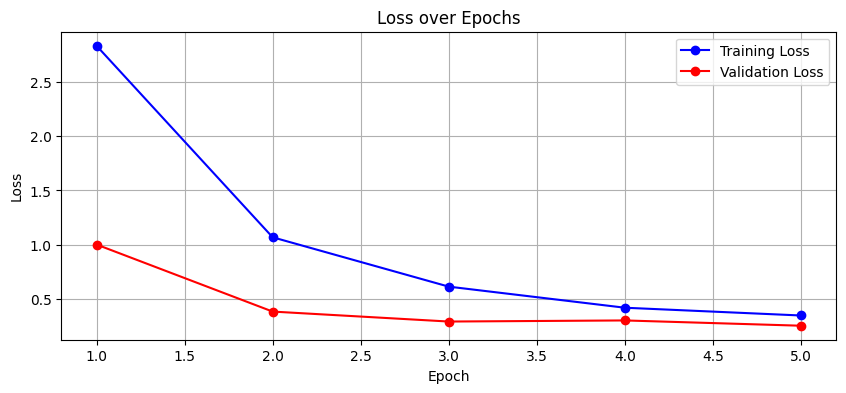

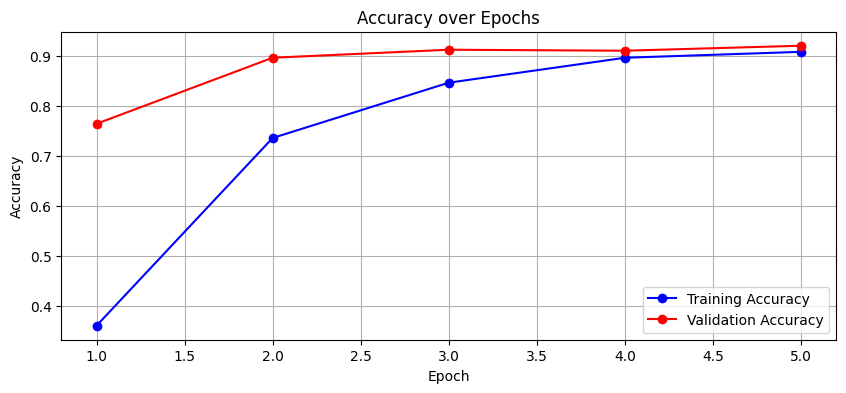

In [13]:
epochs = range(1, num_epochs + 1)

# --- Loss ---
plt.figure(figsize=(10,4))
plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
plt.plot(epochs, valid_losses, 'r-o', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- Accuracy ---
plt.figure(figsize=(10,4))
plt.plot(epochs, train_accuracies, 'b-o', label='Training Accuracy')
plt.plot(epochs, valid_accuracies, 'r-o', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Evaluate model on test data

In [14]:
base_model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = base_model(inputs)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item() * inputs.size(0)
        
        _, preds = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (preds == labels).sum().item()
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Final metrics
test_loss /= len(test_loader.dataset)
test_acc = test_correct / test_total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.1872
Test Accuracy: 0.9360


<Figure size 1000x800 with 0 Axes>

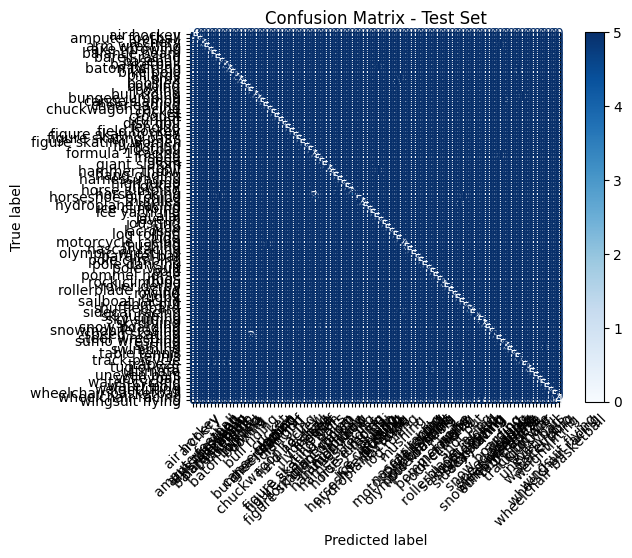

In [17]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=test_dataset.classes)

plt.figure(figsize=(10, 8))
disp.plot(cmap="Blues", xticks_rotation=45, values_format="d")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Display some predictions 

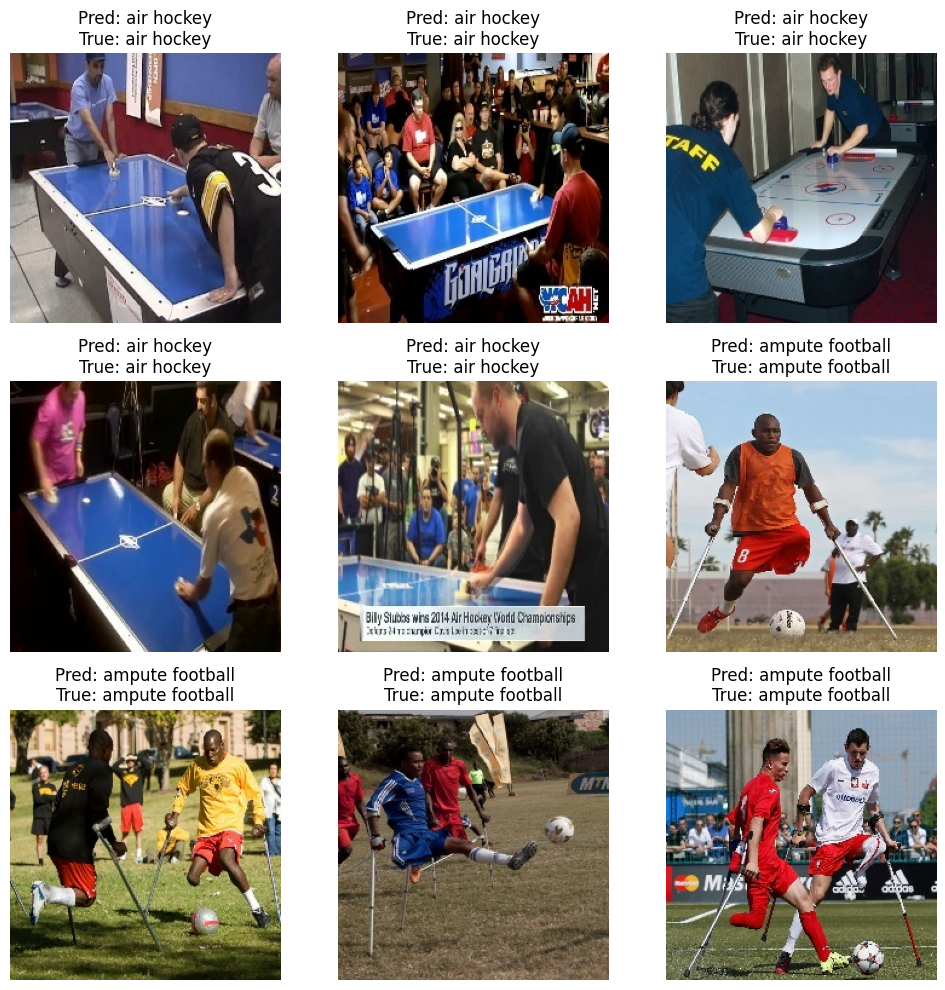

In [19]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = inp * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

# Show 9 predictions
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)

with torch.no_grad():
    outputs = base_model(inputs)
    _, preds = torch.max(outputs, 1)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    imshow(inputs[i].cpu(), 
           title=f"Pred: {test_dataset.classes[preds[i]]}\nTrue: {test_dataset.classes[labels[i]]}")
plt.tight_layout()
plt.show()